#Portrait Segmentation aka Image Matting using U-Nets
This is one of the classical problem in the field of computer vision. Matting is an attempt to separate foreground from background.

Approach flow is given below:

1. Converting the images and their respective masks to npy arrays to avoid the redundancy of reading the images for every run
2. Train-Validation split
3. Prepare the architecture of the U-Net
4. Train the U-Net architecture using the keras data generator
5. Running the trained model for test dataset and computing their IOU and Dice coefficient

In [0]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import Libraries
import os
import numpy as np
import cv2
from random import randint
import pickle
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [0]:
# Change Working directory path
os.chdir('/content/drive/My Drive/Portrait_Segmentation/CelebAMask-HQ')

Dataset Credits: https://github.com/switchablenorms/CelebAMask-HQ

In [0]:
class convert_images:
    def read_images(image_path, mask_path, image_size=(512,512)):
        image_dict = {}
        mask_dict = {}
        for img in os.listdir(image_path):
            try:
              image_dict[img] = cv2.resize(cv2.imread(os.path.join(image_path,img)),(512,512))
            except:
              continue
            hair = ['{0:05}'.format(int(img.split('.',1)[0])) + '_hair']
            r_ear = ['{0:05}'.format(int(img.split('.',1)[0])) + '_r_ear']
            l_ear = ['{0:05}'.format(int(img.split('.',1)[0])) + '_l_ear']
            nose = ['{0:05}'.format(int(img.split('.',1)[0])) + '_nose']
            skin = ['{0:05}'.format(int(img.split('.',1)[0])) + '_skin']
            cloth = ['{0:05}'.format(int(img.split('.',1)[0])) + '_cloth']
            neck = ['{0:05}'.format(int(img.split('.',1)[0])) + '_neck']
            hair_image = cv2.imread(os.path.join(mask_path,hair[0]+'.png'))
            if not os.path.exists(os.path.join(mask_path,hair[0]+'.png')):
                hair_image = np.zeros(image_dict[img].shape)
            r_ear_image = cv2.imread(os.path.join(mask_path,r_ear[0]+'.png'))
            if not os.path.exists(os.path.join(mask_path,r_ear[0]+'.png')):
                r_ear_image = np.zeros(image_dict[img].shape)
            l_ear_image = cv2.imread(os.path.join(mask_path,l_ear[0]+'.png'))
            if not os.path.exists(os.path.join(mask_path,l_ear[0]+'.png')):
                l_ear_image = np.zeros(image_dict[img].shape)
            nose_image = cv2.imread(os.path.join(mask_path,nose[0]+'.png'))
            if not os.path.exists(os.path.join(mask_path,nose[0]+'.png')):
                nose_image = np.zeros(image_dict[img].shape)
            skin_image = cv2.imread(os.path.join(mask_path,skin[0]+'.png'))
            if not os.path.exists(os.path.join(mask_path,skin[0]+'.png')):
                skin_image = np.zeros(image_dict[img].shape)
            cloth_image = cv2.imread(os.path.join(mask_path,cloth[0]+'.png'))
            if not os.path.exists(os.path.join(mask_path,cloth[0]+'.png')):
                cloth_image = np.zeros(image_dict[img].shape)
            neck_image = cv2.imread(os.path.join(mask_path,neck[0]+'.png'))
            if not os.path.exists(os.path.join(mask_path,neck[0]+'.png')):
                neck_image = np.zeros(image_dict[img].shape)
            mask_dict[img] = hair_image+r_ear_image+l_ear_image+nose_image+skin_image+cloth_image+neck_image
        return (image_dict, mask_dict)
    def to_npy(image_dict,mask_dict):
        image = []
        mask = []
        for img, msk in zip(image_dict.values(), mask_dict.values()):
          image.append(img)
          mask.append(msk.astype('uint16'))
        image = np.array(image)
        mask = np.array(mask)

        mask = mask[:,:,:,1]
        mask = np.expand_dims(mask, axis=-1)
        print('Saving the images as .npy files')
        np.save('Images',image)
        np.save('Masks',mask)

In [0]:
# Give the path for the Images and masks
images_path = os.path.join(os.getcwd(),"CelebA-HQ-img/")
mask_path = os.path.join(os.getcwd(),"CelebAMask-HQ-mask-anno/0")

# Save the images to .npy files
image_dict, mask_dict = convert_images.read_images(images_path, mask_path)
convert_images.to_npy(image_dict, mask_dict)

In [0]:
# Load Images and their respective masks
X = np.load(os.path.join(os.getcwd(),"Images.npy"))
Y = np.load(os.path.join(os.getcwd(),"Masks.npy"))

In [0]:
# Converting the masks to binary format
Y = np.where(Y > 1, 1, 0)

In [0]:
print("Number of Images:", X.shape[0])
print("Shape of Images:", X.shape[1],"x", X.shape[1])

print("Number of Masks:", Y.shape[0])
print("Shape of Masks:", Y.shape[1],"x", Y.shape[1])

Number of Images: 2000
Shape of Images: 512 x 512
Number of Masks: 2000
Shape of Masks: 512 x 512


<Figure size 720x720 with 0 Axes>

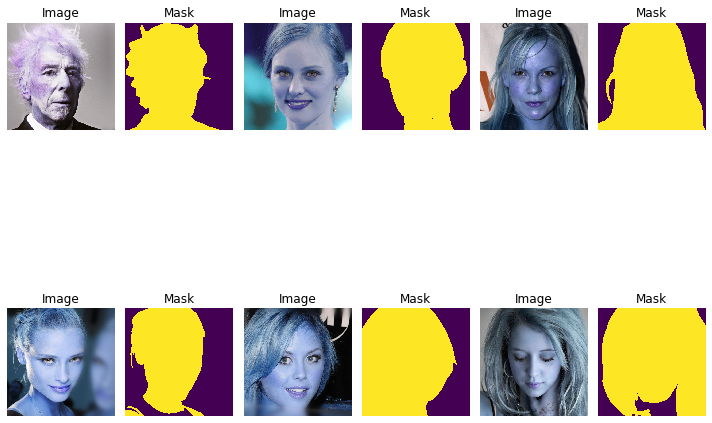

In [0]:
# Visualize the Images and their Masks
fig = plt.figure(figsize=(10,10))
plt.subplots(2, 4, figsize=(10,10), sharex='row',gridspec_kw={'hspace': 0, 'wspace': 0})

idx = randint(0, X.shape[0] - 1)

for i in list(np.linspace(1,11,6,dtype = int)):
  plt.subplot(2,6,i)
  plt.imshow(X[idx + i,:,:,:])
  plt.axis("off")
  plt.title('Image')

  plt.subplot(2,6,i+1)
  plt.imshow(Y[idx + i,:,:,0])
  plt.axis("off")
  plt.title('Mask')

plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.show()

In [0]:
# Train Validation Split
def train_val_split(X, Y, valid_split=0.8):
    num_images = X.shape[0]
    x_train = X[:int(valid_split * num_images),:,:,:]
    y_train = Y[:int(valid_split * num_images),:,:,0]
    y_train = np.expand_dims(y_train, axis=-1)

    x_valid = X[int(valid_split * num_images):,:,:,:]
    y_valid = Y[int(valid_split * num_images):,:,:,0]
    y_valid = np.expand_dims(y_valid, axis=-1)

    return x_train, y_train, x_valid, y_valid

In [0]:
x_train, y_train, x_valid, y_valid = train_val_split(X,Y)
del X
del Y

In [0]:
# Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator()

Defining the U-Net Architecture

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
def unet_model(input_size=(512,512,3)):
  inputs = Input(input_size)

  # normalize the images
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  model.compile(optimizer='adam', loss='binary_crossentropy')

  model.summary()
  return model

In [0]:
batch_size = 4
model = unet_model()
history = model.fit_generator(image_datagen.flow(x_train, y_train, batch_size = batch_size), 
                              steps_per_epoch=x_train.shape[0]/batch_size,
                              validation_data=(x_valid, y_valid), 
                              validation_steps=x_valid.shape[0]/batch_size,
                              epochs=100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         lambda_1[0][0]                   
_________________________________________________________________________

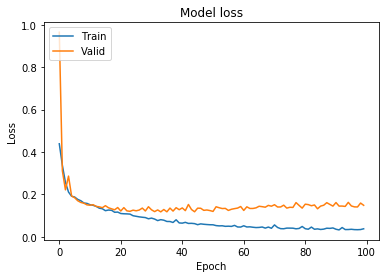

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [0]:
# Saving the model
model.save('model.h5')

Testing Phase

In [0]:
# Load the model
model = load_model('model.h5')

# Read the Test Images and their respective masks
x_test = np.load(os.path.join(os.getcwd(),"Test_Images.npy"))
y_test = np.load(os.path.join(os.getcwd(),"Test_Masks.npy"))

# Convert Masks to Binary Masks
y_test = np.where(y_test > 1, 1, 0)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
import timeit
start = timeit.default_timer()

output = []
for test_img in x_test:
  output.append(model.predict(test_img.reshape(1,512,512,3))[0,:,:,:])
output = np.array(output)

stop = timeit.default_timer()

# Convert pixel values from float to integer
output = np.where(output > 0.9, 1, 0)
output = output.astype('uint8')

print('Time to inference the model for a single image:', (stop-start)/test_img.shape[0],'s')
print('A 30 FPS real-time engine will require ',1/30,'s inference time for a single Image')

Time to inference the model for a single image: 0.02311286977539062 s
A 30 FPS real-time engine will require  0.03333333333333333 s inference time for a single Image


Dilation Operation on the predicted masks to smooth out the masks

In [0]:
  kernel = np.ones((15,15),np.uint8)
  dilate_opt = []
  for image in output:
    dilate_opt.append(cv2.dilate(image,kernel,iterations = 1))
  dilate_opt = np.array(dilate_opt)
  dilate_opt = np.expand_dims(dilate_opt, axis=-1)

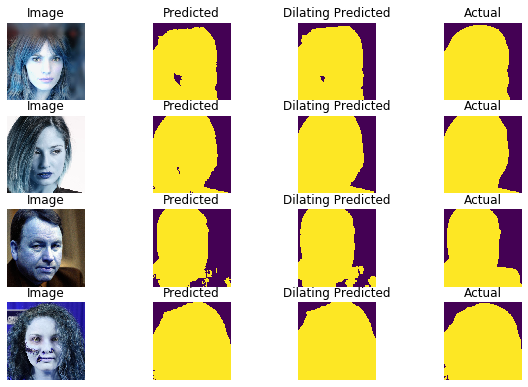

In [0]:
plt.figure(figsize=(10,10))

for i in list(np.linspace(1,13,4, dtype = int)):
  idx = randint(0,50)
  plt.subplot(6,4,i)
  plt.title('Image')
  plt.axis('off')
  plt.imshow(x_test[idx,:,:,:])

  plt.subplot(6,4,i+1)
  plt.title('Predicted')
  plt.axis('off')
  plt.imshow(output[idx,:,:,0])

  plt.subplot(6,4,i+2)
  plt.title('Dilating Predicted')
  plt.axis('off')
  plt.imshow(dilate_opt[idx,:,:,0])

  plt.subplot(6,4,i+3)
  plt.title('Actual')
  plt.axis('off')
  plt.imshow(y_test[idx,:,:,0])

plt.show()

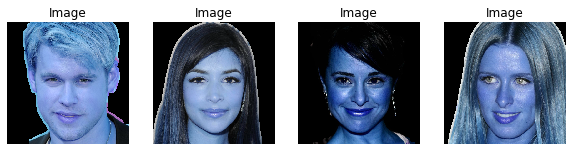

In [0]:
plt.figure(figsize=(10,10))

for i in list(np.linspace(1,4,4, dtype = int)):
  idx = randint(0,x_test.shape[0])
  plt.subplot(1,4,i)
  plt.title('Image')
  plt.axis('off')
  plt.imshow(cv2.bitwise_and(x_test[idx,:,:,:], x_test[idx,:,:,:], mask = dilate_opt.astype('uint8')[idx,:,:,0]))

plt.show()

In [0]:
# Calculate IOU Score
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

# Calculate Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [0]:
iou_score = iou_coef(y_test, dilate_opt.astype('int64'))
dice_score = dice_coef(y_test, dilate_opt.astype('int64'))

In [0]:
sess = tf.Session()
print('IOU Score on the test dataset:', sess.run(iou_score))
print('Dice Coefficient on the test dataset:', sess.run(dice_score))

IOU Score on the test dataset: 0.9207022263231106
Dice Coefficient on the test dataset: 0.9566789074297841


Result Summary:

1. IOU Score ~ 92%
   (Which means we correctly predicted 92% of area correctly w.r.t actual mask)
   
   Formula: (Area of overlap)/(Area of union)

2. Dice Coefficient ~ 95% (Similar to IOU score)

   Formula: (2 * Area of Overlap)/(Total number of pixels)